In [1]:

import polars as pl
import pandas as pd
import numpy as np
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances
import warnings
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr
from collections import Counter
from scipy.stats import norm
import os
# add preprocess module to path
import sys
sys.path.append('../../src/utils')

from preprocess import * 




### Load ATAC and RNA data (log transform RNA)

In [2]:
# load atac data with polars and convert to pandas (faster)
atac_data_pl = pl.read_csv('../../data/embryo/raw/atac_peak_matrix_complete_sparse.csv')
atac_data_df = atac_data_pl.to_pandas(use_pyarrow_extension_array=False)


In [3]:
rna_data_pl = pl.read_csv('../../data/embryo/raw/scRNA_countMatrix.csv', ignore_errors=True)
rna_data_df = rna_data_pl.to_pandas(use_pyarrow_extension_array=False)
rna_data_df.set_index(rna_data_df.columns[0], inplace=True)
rna_data_df[rna_data_df.isna().any(axis=1)].dropna(axis=0, how='any', inplace=True)
rna_data_log = rna_data_df.copy()
rna_data_log.iloc[:, 0:] = np.log2(rna_data_log.iloc[:, 0:].astype(float) + 1)
print(f"shape of rna_data_log: {rna_data_log.shape}")
rna_data_log.head()



/tmp/ipykernel_2004372/4212779021.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_data_df[rna_data_df.isna().any(axis=1)].dropna(axis=0, how='any', inplace=True)


shape of rna_data_log: (26544, 68853)


,10h-1_CELL1140_N1_10h-1,10h-1_CELL1447_N1_10h-1,10h-1_CELL1347_N1_10h-1,10h-1_CELL1204_N1_10h-1,10h-1_CELL97_N2_10h-1,10h-1_CELL539_N1_10h-1,10h-1_CELL310_N1_10h-1,10h-1_CELL311_N1_10h-1,10h-1_CELL665_N1_10h-1,10h-1_CELL350_N1_10h-1,...,6h_3 CELL3882_N1 _,6h_3 CELL5301_N1 _,6h_3 CELL5240_N1 _,6h_3 CELL5143_N1 _,6h_3 CELL5575_N1 _,6h_3 CELL5349_N1 _,6h_3 CELL4434_N1 _,6h_3 CELL5403_N1 _,6h_3 CELL5489_N1 _,6h_3 CELL5447_N1 _
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.554589,4.523562,4.807355,4.247928,6.209453,6.228819,6.507795,6.599913,5.882643,5.754888,...,2.321928,0.000000,1.584963,2.000000,1.584963,1.584963,2.000000,3.000000,1.000000,1.000000
khdrbs1a,6.357552,5.906891,5.209453,5.930737,7.294621,7.375039,7.531381,7.599913,6.894818,7.228819,...,5.459432,4.906891,4.459432,3.906891,4.584963,4.584963,5.129283,4.584963,4.807355,5.700440
apoeb,6.614710,6.870365,7.599913,4.700440,4.754888,9.144658,6.554589,5.554589,6.569856,7.149747,...,3.584963,3.000000,3.321928,4.087463,4.321928,3.459432,4.321928,2.321928,1.584963,1.000000
cfl1,3.584963,3.321928,3.459432,4.459432,4.954196,5.247928,5.614710,6.044394,4.906891,5.392317,...,3.169925,2.000000,1.584963,1.000000,2.000000,1.584963,3.169925,2.584963,2.000000,2.807355
polr2d,2.584963,1.000000,1.000000,2.807355,2.000000,2.000000,2.584963,2.807355,1.000000,3.000000,...,0.000000,0.000000,0.000000,1.584963,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000


### Load ATAC and RNA metadta

In [4]:
rna_metadata_df = pd.read_csv('../../data/embryo/raw/rna_all.metaData.txt')
rna_metadata_df.rename(columns = {'Unnamed: 0': 'rna_cell'}, inplace=True)
print(f"shape of rna_metadata: {rna_metadata_df.shape}")
rna_metadata_df.head()

shape of rna_metadata: (68853, 8)


,rna_cell,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,seurat_clusters,stage,celltype
0,10h-1_CELL1140_N1_10h-1,10h-1,16009,3354,1.467924,14,10hpf,anterior neural keel
1,10h-1_CELL1447_N1_10h-1,10h-1,11259,2505,1.367795,3,10hpf,neurogenic placode
2,10h-1_CELL1347_N1_10h-1,10h-1,12532,2806,1.324609,22,10hpf,epithelial Cell
3,10h-1_CELL1204_N1_10h-1,10h-1,14432,3312,1.489745,8,10hpf,tail bud
4,10h-1_CELL97_N2_10h-1,10h-1,31455,4443,1.176284,2,10hpf,posterior neural keel


In [5]:
atac_metadata_df = (
    pd.read_csv('../../data/embryo/raw/atac_all.metaData.txt', index_col=0)[['celltype', 'predictedCell', 'predictedGroup']]
    .rename(columns={'celltype': 'atac_cell_type','predictedCell': 'rna_matching_cell', 'predictedGroup': 'rna_cell_type'})
    .reset_index(names="atac_cell"))

atac_metadata_df = atac_metadata_df.assign(rna_stage=lambda df: df['rna_matching_cell'].apply(extract_stage, args=('h', 0)),
    atac_stage=lambda df: df['atac_cell'].apply(extract_stage, args=('hpf', 0)), pseudobulk=lambda df: df['atac_stage'] + '_' + df['atac_cell_type'])

atac_metadata_df.head()


,atac_cell,atac_cell_type,rna_matching_cell,rna_cell_type,rna_stage,atac_stage,pseudobulk
0,3hpf_1#3hpf_1_merge_BC0443_N27,blastomere,6h_3 CELL4645_N1 _,margin,6,3,3_blastomere
1,3hpf_1#3hpf_1_merge_BC0069_N07,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
2,3hpf_1#3hpf_1_merge_BC0033_N05,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
3,3hpf_1#3hpf_1_merge_BC0028_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere
4,3hpf_1#3hpf_1_merge_BC0264_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere


In [6]:
atac_mean_raw, atac_std_raw = create_pseudobulk_stats(atac_data_df, atac_metadata_df, value_column="Accessibility", norm_reads=False)

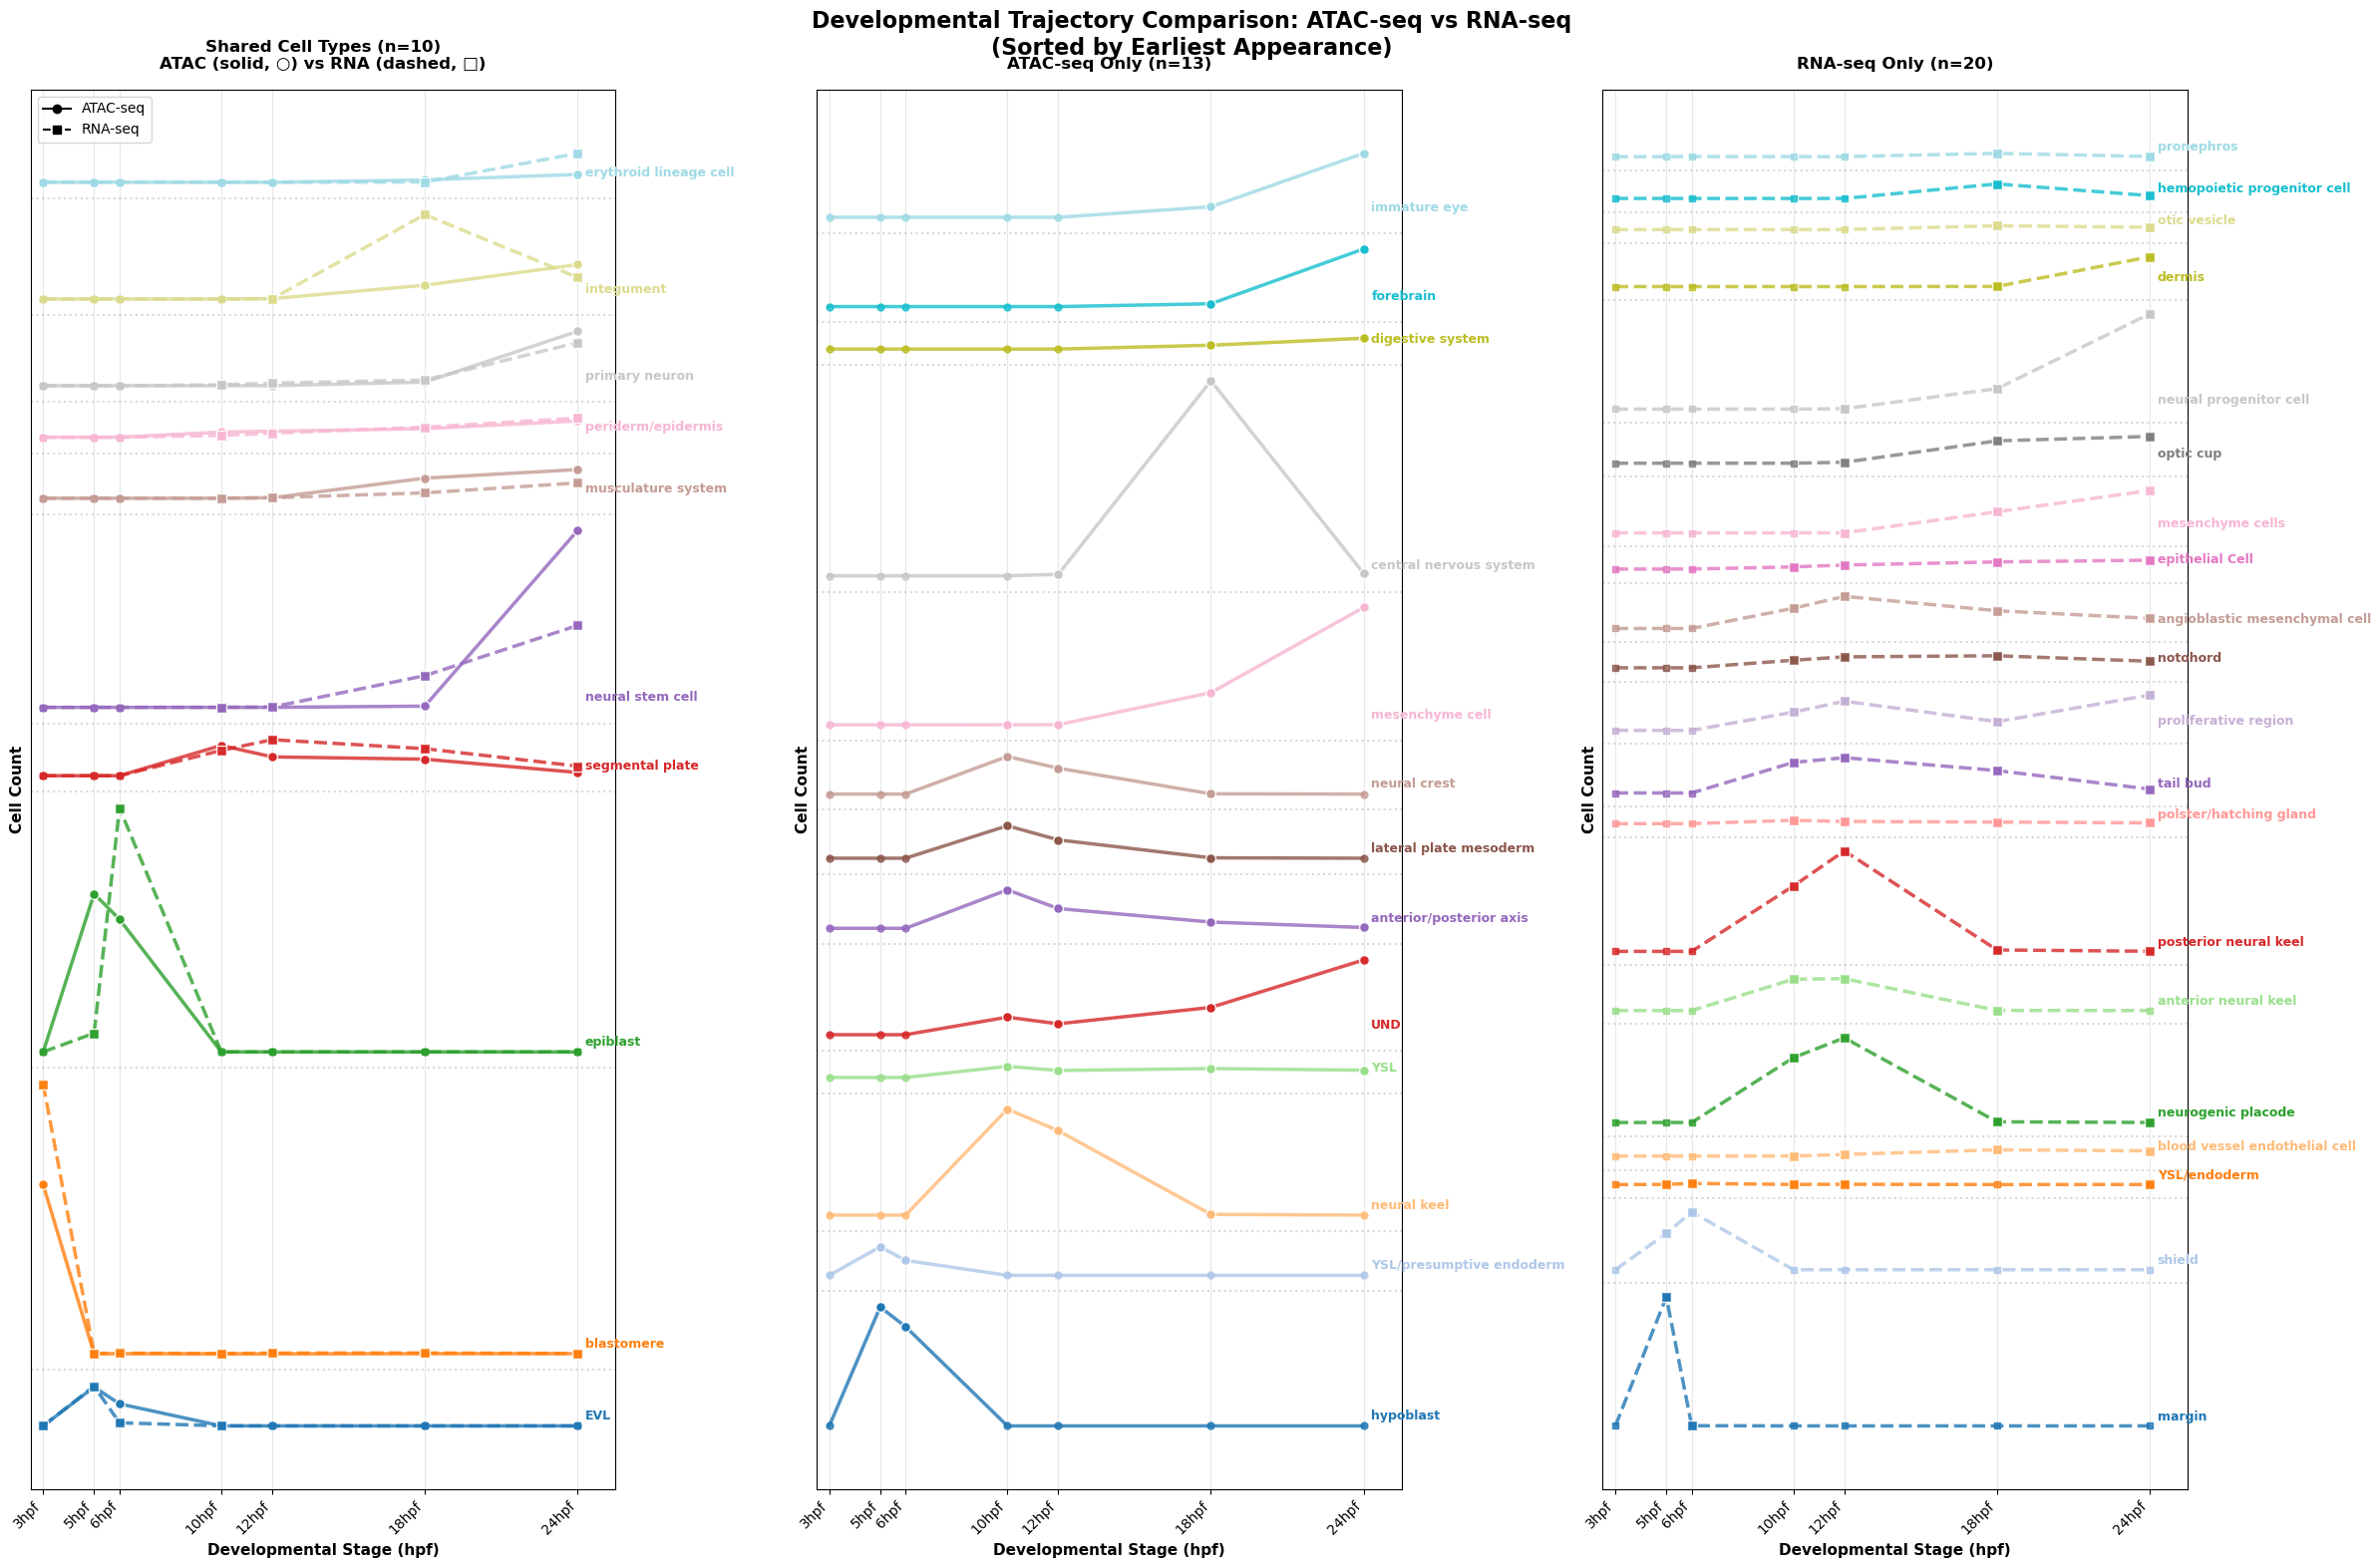

In [7]:

atac_available = atac_metadata_df is not None and {'atac_cell_type', 'atac_stage'}.issubset(atac_metadata_df.columns)
atac_heatmap = process_trajectory_data(atac_metadata_df, 'atac_cell_type', 'atac_stage') if atac_available else None
rna_heatmap = process_trajectory_data(rna_metadata_df, 'celltype', 'stage')

common_cell_types = set(atac_heatmap.index) & set(rna_heatmap.index) if atac_available else set()
atac_only = set(atac_heatmap.index) - set(rna_heatmap.index) if atac_available else set()
rna_only = set(rna_heatmap.index) - set(atac_heatmap.index) if atac_available else set()
all_stages = sorted(set(atac_heatmap.columns if atac_available else []) | set(rna_heatmap.columns))

fig, axes = plt.subplots(1, 3, figsize=(24, 16))

plot_trajectories(axes[0], common_cell_types, atac_heatmap, rna_heatmap, all_stages, f'Shared Cell Types (n={len(common_cell_types)})\nATAC (solid, ○) vs RNA (dashed, □)', 'shared')
plot_trajectories(axes[1], atac_only, atac_heatmap, None, all_stages, f'ATAC-seq Only (n={len(atac_only)})', 'atac_only')
plot_trajectories(axes[2], rna_only, None, rna_heatmap, all_stages, f'RNA-seq Only (n={len(rna_only)})', 'rna_only')

fig.suptitle('Developmental Trajectory Comparison: ATAC-seq vs RNA-seq\n(Sorted by Earliest Appearance)',
             fontsize=16, fontweight='bold', y=0.98)

if common_cell_types and atac_available:
    legend_elements = [plt.Line2D([0], [0], color='black', linestyle='-', marker='o', label='ATAC-seq'), plt.Line2D([0], [0], color='black', linestyle='--', marker='s', label='RNA-seq')]
    axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('../../data/embryo/plotsatac_rna_developmental_trajectories_comparison.png', bbox_inches='tight')
plt.show()



#### Only 2258 RNA cells are assigned to ATAC cells

In [8]:
# filter rna_data_log to only keep the rows with max  value >=4
rna_log_high_genes = rna_data_log[rna_data_log.max(axis=1) >= 4]
print(f"Filtered RNA log data shape: {rna_log_high_genes.shape}")
rna_log_high_genes.head()

Filtered RNA log data shape: (9205, 68853)


,10h-1_CELL1140_N1_10h-1,10h-1_CELL1447_N1_10h-1,10h-1_CELL1347_N1_10h-1,10h-1_CELL1204_N1_10h-1,10h-1_CELL97_N2_10h-1,10h-1_CELL539_N1_10h-1,10h-1_CELL310_N1_10h-1,10h-1_CELL311_N1_10h-1,10h-1_CELL665_N1_10h-1,10h-1_CELL350_N1_10h-1,...,6h_3 CELL3882_N1 _,6h_3 CELL5301_N1 _,6h_3 CELL5240_N1 _,6h_3 CELL5143_N1 _,6h_3 CELL5575_N1 _,6h_3 CELL5349_N1 _,6h_3 CELL4434_N1 _,6h_3 CELL5403_N1 _,6h_3 CELL5489_N1 _,6h_3 CELL5447_N1 _
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.554589,4.523562,4.807355,4.247928,6.209453,6.228819,6.507795,6.599913,5.882643,5.754888,...,2.321928,0.000000,1.584963,2.000000,1.584963,1.584963,2.000000,3.000000,1.000000,1.000000
khdrbs1a,6.357552,5.906891,5.209453,5.930737,7.294621,7.375039,7.531381,7.599913,6.894818,7.228819,...,5.459432,4.906891,4.459432,3.906891,4.584963,4.584963,5.129283,4.584963,4.807355,5.700440
apoeb,6.614710,6.870365,7.599913,4.700440,4.754888,9.144658,6.554589,5.554589,6.569856,7.149747,...,3.584963,3.000000,3.321928,4.087463,4.321928,3.459432,4.321928,2.321928,1.584963,1.000000
cfl1,3.584963,3.321928,3.459432,4.459432,4.954196,5.247928,5.614710,6.044394,4.906891,5.392317,...,3.169925,2.000000,1.584963,1.000000,2.000000,1.584963,3.169925,2.584963,2.000000,2.807355
polr2d,2.584963,1.000000,1.000000,2.807355,2.000000,2.000000,2.584963,2.807355,1.000000,3.000000,...,0.000000,0.000000,0.000000,1.584963,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000


In [9]:
# continue with log values anf filtered genes 
# split the rna_data_log into matched and unmatched based on the atac_metadata_df
matching_cells = atac_metadata_df['rna_matching_cell'].str.strip().unique().tolist()
rna_data_matched_all_genes = rna_data_log.loc[:, rna_data_log.columns.intersection(matching_cells)]
rna_data_unmatched_all_genes =rna_data_log.loc[:, ~rna_data_log.columns.isin(matching_cells)]
matching_cells = atac_metadata_df['rna_matching_cell'].str.strip().unique().tolist()
rna_high_genes_Matched = rna_log_high_genes.loc[:, rna_log_high_genes.columns.intersection(matching_cells)]
rna_high_genes_Unmatched = rna_log_high_genes.loc[:, ~rna_log_high_genes.columns.isin(matching_cells)]
print("shape of rna_high_genes_Matched:", rna_high_genes_Matched.shape)
print("shape of rna_high_genes_Unmatched:", rna_high_genes_Unmatched.shape)

rna_high_genes_Unmatched.head()

shape of rna_high_genes_Matched: (9205, 2258)
shape of rna_high_genes_Unmatched: (9205, 66595)


,10h-1_CELL1140_N1_10h-1,10h-1_CELL1447_N1_10h-1,10h-1_CELL1347_N1_10h-1,10h-1_CELL1204_N1_10h-1,10h-1_CELL97_N2_10h-1,10h-1_CELL539_N1_10h-1,10h-1_CELL310_N1_10h-1,10h-1_CELL311_N1_10h-1,10h-1_CELL665_N1_10h-1,10h-1_CELL350_N1_10h-1,...,6h_3 CELL3882_N1 _,6h_3 CELL5301_N1 _,6h_3 CELL5240_N1 _,6h_3 CELL5143_N1 _,6h_3 CELL5575_N1 _,6h_3 CELL5349_N1 _,6h_3 CELL4434_N1 _,6h_3 CELL5403_N1 _,6h_3 CELL5489_N1 _,6h_3 CELL5447_N1 _
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.554589,4.523562,4.807355,4.247928,6.209453,6.228819,6.507795,6.599913,5.882643,5.754888,...,2.321928,0.000000,1.584963,2.000000,1.584963,1.584963,2.000000,3.000000,1.000000,1.000000
khdrbs1a,6.357552,5.906891,5.209453,5.930737,7.294621,7.375039,7.531381,7.599913,6.894818,7.228819,...,5.459432,4.906891,4.459432,3.906891,4.584963,4.584963,5.129283,4.584963,4.807355,5.700440
apoeb,6.614710,6.870365,7.599913,4.700440,4.754888,9.144658,6.554589,5.554589,6.569856,7.149747,...,3.584963,3.000000,3.321928,4.087463,4.321928,3.459432,4.321928,2.321928,1.584963,1.000000
cfl1,3.584963,3.321928,3.459432,4.459432,4.954196,5.247928,5.614710,6.044394,4.906891,5.392317,...,3.169925,2.000000,1.584963,1.000000,2.000000,1.584963,3.169925,2.584963,2.000000,2.807355
polr2d,2.584963,1.000000,1.000000,2.807355,2.000000,2.000000,2.584963,2.807355,1.000000,3.000000,...,0.000000,0.000000,0.000000,1.584963,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000


In [10]:
rna_unmatched_all = rna_data_unmatched_all_genes.copy()

##### Define a cutoff for each pseudobulk as the distance between this (mean vector of same psd cells) and the most distant cell of the same celltype (from any time point).
##### Compute the distance from same cell type cells to each pseudobulk considering only genes with max log expression >=4
    - To enrich the pseudobulks with unmatched RNA cells we will use this cutoff
    - If a new cell has a distance > cutoff, it is more different than any cell of that type used to define the pseudobulk 

In [ ]:
cutoffs_high_exp_genes_Celltype = compute_pseudobulk_cutoffs_df(rna_high_genes_Matched, atac_metadata_df, cutoff_mode='celltype')
cutoffs_high_exp_genes_Pseudobulk = compute_pseudobulk_cutoffs_df(rna_high_genes_Matched, atac_metadata_df, cutoff_mode='pseudobulk')
cutoffs_high_exp_genes_Pseudobulk.head()

,pseudobulk,atac_cell_type,cutoff,n_cells_in_pseudobulk,n_cells_same_type
0,12_neural keel,neural keel,138.797406,1557,3525
1,18_central nervous system,central nervous system,173.781686,3599,3672
2,10_neural crest,neural crest,118.594639,694,1177
3,12_neural crest,neural crest,117.974890,478,1177
4,12_integument,integument,125.629656,10,1336


In [12]:

valid_pseudobulks = atac_mean_raw.columns
rna_mean_filtered_genes = create_rna_mean(rna_high_genes_Matched, atac_metadata_df, valid_pseudobulks)
rna_std_filtered_genes = create_rna_std(rna_high_genes_Unmatched, atac_metadata_df, valid_pseudobulks)
rna_mean_all_genes = create_rna_mean(rna_data_matched_all_genes, atac_metadata_df, valid_pseudobulks)
rna_std_all_genes = create_rna_std(rna_data_matched_all_genes, atac_metadata_df, valid_pseudobulks)



/sasselab3/home/mourouzidou/zebrafish_development/notebooks/embryo/../../src/utils/preprocess.py:768: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return rna_data_filtered.groupby(level=0, axis=1).mean()
/sasselab3/home/mourouzidou/zebrafish_development/notebooks/embryo/../../src/utils/preprocess.py:774: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return rna_data_filtered.groupby(level=0, axis=1).std()
/sasselab3/home/mourouzidou/zebrafish_development/notebooks/embryo/../../src/utils/preprocess.py:768: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return rna_data_filtered.groupby(level=0, axis=1).mean()
/sasselab3/home/mourouzidou/zebrafish_development/notebooks/embryo/../../src/utils/preprocess.py:774: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` withou

#### assign pseudobulk labels on unmatched cells 
        - considering all genes
        - considering only the genees with argmax log2(x+1) >4
#### Some pseudobulks have 0 marker genes - they also have few cells assigned from the original assignment

In [16]:
from scipy.stats import norm
def find_marker_genes(rna_data, metadata_df, grouping_column, 
                     cell_id_column='rna_matching_cell',
                     pvalue_threshold=0.05, log_fc_threshold=0.5):
    
    # Create cell-to-group mapping and rename columns
    cell_to_group = metadata_df.set_index(cell_id_column)[grouping_column].to_dict()
    rna_data_grouped = rna_data.rename(columns=cell_to_group)
    
    # Compute group-level statistics
    group_counts = rna_data_grouped.columns.value_counts()
    rna_data_mean_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).mean()
    rna_data_std_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).std()
    
    # Perform t-tests for each group
    genes = rna_data_mean_group.index
    groups = rna_data_mean_group.columns
    marker_genes = {}
    
    for target_group in groups:        
        other_groups = [group for group in groups if group != target_group]
        
        # Extract statistics for target group
        mu1 = rna_data_mean_group[target_group]
        sd1 = rna_data_std_group[target_group]
        n1 = group_counts[target_group]
    
        mu2 = rna_data_mean_group[other_groups].mean(axis=1)
        sd2 = rna_data_std_group[other_groups].mean(axis=1)
        n2 = group_counts[other_groups].mean()
        
        # Welch's t-test with normal approximation
        numerator = mu1 - mu2
        denominator = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)
        t_stats = numerator / denominator
        
        t_stats = t_stats.replace([np.inf, -np.inf], np.nan).fillna(0)

        p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))
        
        _, pvals_corrected, _, _ = multipletests(p_values, method="fdr_bh")
        
        log_fc = mu1 - mu2
        
        mask = (pvals_corrected < pvalue_threshold) & (log_fc > log_fc_threshold)
        marker_genes[target_group] = list(genes[mask])

    
    return marker_genes
marker_genes_celltype_high_exp_genes= find_marker_genes(rna_data=rna_high_genes_Matched, metadata_df=atac_metadata_df, grouping_column='atac_cell_type', pvalue_threshold=0.05, log_fc_threshold=0)



/tmp/ipykernel_2004372/409759964.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).mean()
/tmp/ipykernel_2004372/409759964.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).std()


In [17]:
marker_genes_set = marker_genes_celltype_high_exp_genes.values() # create a marker gene hyperset to only consider the genes that are in the marker genes set
marker_genes_set = {gene for sublist in marker_genes_set for gene in sublist}
len(marker_genes_set)

8306

/tmp/ipykernel_2004372/409759964.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).mean()
/tmp/ipykernel_2004372/409759964.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).std()
/tmp/ipykernel_2004372/409759964.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).mean()
/tmp/ipykernel_2004372/409759964.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).std()


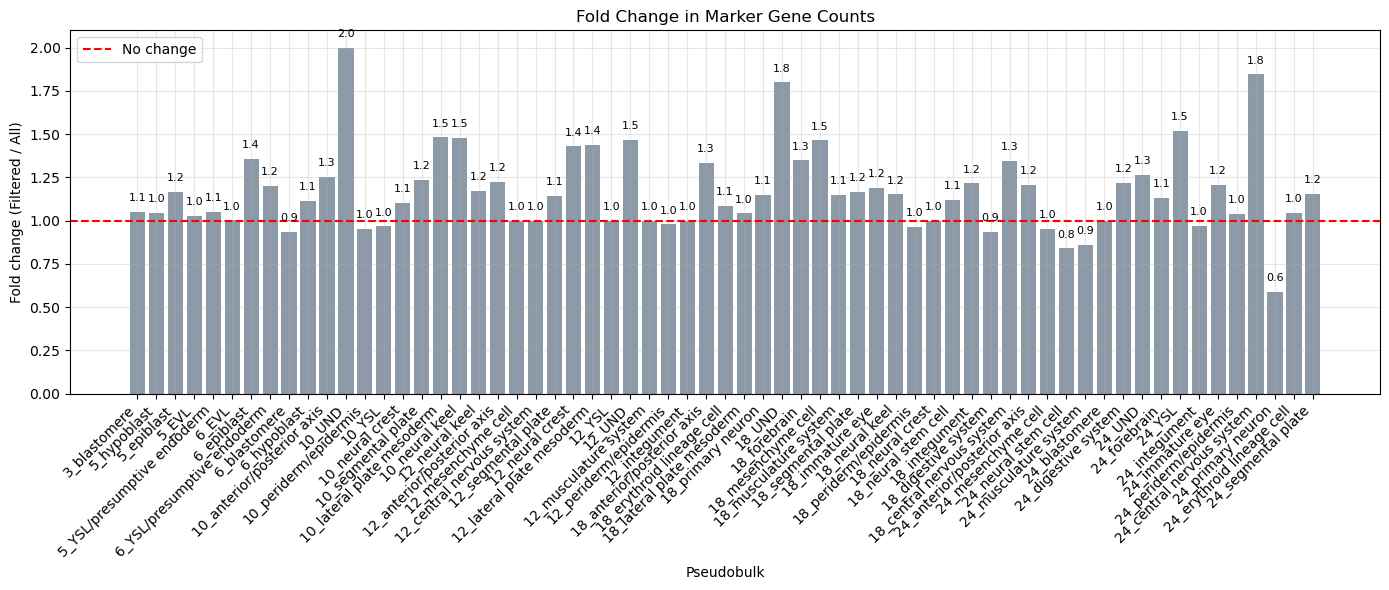

In [ ]:
marker_genes_pseudobulk = find_marker_genes(
    rna_data=rna_data_matched_all_genes,
    metadata_df=atac_metadata_df,
    grouping_column='pseudobulk',
    pvalue_threshold=0.05,
    log_fc_threshold=0
)


marker_genes_pseudobulk_high_exp_genes= find_marker_genes(
    rna_data=rna_high_genes_Matched,
    metadata_df=atac_metadata_df,
    grouping_column='pseudobulk',
    pvalue_threshold=0.05,
    log_fc_threshold=0
)

results = plot_marker_gene_fold_change(marker_genes_pseudobulk, 
    marker_genes_pseudobulk_high_exp_genes)

In [25]:
# filter rows of rna_mean_filtereed_genes to only keep rows that are in marker_genes_set
rna_mean_markers = rna_mean_filtered_genes.loc[rna_mean_filtered_genes.index.intersection(marker_genes_set)]
# filter rna_high_genes_Unmatched to have the same genes as rna_mean_markers
rna_high_genes_Unmatched_markers = rna_high_genes_Unmatched.loc[rna_high_genes_Unmatched.index.intersection(marker_genes_set)]
rna_mean_markers.head()

,10_UND,10_YSL,10_anterior/posterior axis,10_lateral plate mesoderm,10_neural crest,10_neural keel,10_periderm/epidermis,10_segmental plate,12_UND,12_YSL,...,3_blastomere,5_EVL,5_YSL/presumptive endoderm,5_epiblast,5_hypoblast,6_EVL,6_YSL/presumptive endoderm,6_blastomere,6_epiblast,6_hypoblast
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.084864,2.292481,5.977550,5.505295,5.860131,5.471751,4.346743,5.809875,5.433258,1.584963,...,2.850926,4.662160,1.935785,2.623231,3.276358,4.178352,1.905843,2.953445,4.253723,3.285158
khdrbs1a,4.742312,3.284928,6.498762,6.354888,6.985411,6.233713,2.729716,6.072204,5.686432,3.700440,...,5.354773,7.578096,3.043094,6.082239,6.388591,6.952145,4.021294,5.648458,6.490304,6.263180
apoeb,2.446045,6.575984,4.891290,4.907480,6.666729,4.654771,0.000000,4.813227,3.869535,0.000000,...,2.321131,2.223308,5.098626,4.674749,4.360641,1.392333,5.915131,1.000000,5.619259,4.404523
cfl1,3.911818,2.292481,4.642868,4.655234,4.435093,4.392690,0.000000,4.284868,4.602898,3.000000,...,4.364861,5.546121,2.194988,3.169378,3.684791,4.788534,2.364896,4.204695,4.009630,3.561034
polr2d,1.181378,0.000000,1.874917,1.880436,1.776963,1.805762,0.000000,1.900582,1.602456,0.000000,...,1.321714,1.166667,0.000000,0.628456,1.095659,0.685348,0.250000,1.500000,1.641023,1.037416


In [26]:
print(f"shape of Unmatched RNA cells fitler for marker gene hyperset: {rna_high_genes_Unmatched_markers.shape}")
rna_high_genes_Unmatched_markers.head()

shape of Unmatched RNA cells fitler for marker gene hyperset: (8306, 66595)


,10h-1_CELL1140_N1_10h-1,10h-1_CELL1447_N1_10h-1,10h-1_CELL1347_N1_10h-1,10h-1_CELL1204_N1_10h-1,10h-1_CELL97_N2_10h-1,10h-1_CELL539_N1_10h-1,10h-1_CELL310_N1_10h-1,10h-1_CELL311_N1_10h-1,10h-1_CELL665_N1_10h-1,10h-1_CELL350_N1_10h-1,...,6h_3 CELL3882_N1 _,6h_3 CELL5301_N1 _,6h_3 CELL5240_N1 _,6h_3 CELL5143_N1 _,6h_3 CELL5575_N1 _,6h_3 CELL5349_N1 _,6h_3 CELL4434_N1 _,6h_3 CELL5403_N1 _,6h_3 CELL5489_N1 _,6h_3 CELL5447_N1 _
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.554589,4.523562,4.807355,4.247928,6.209453,6.228819,6.507795,6.599913,5.882643,5.754888,...,2.321928,0.000000,1.584963,2.000000,1.584963,1.584963,2.000000,3.000000,1.000000,1.000000
khdrbs1a,6.357552,5.906891,5.209453,5.930737,7.294621,7.375039,7.531381,7.599913,6.894818,7.228819,...,5.459432,4.906891,4.459432,3.906891,4.584963,4.584963,5.129283,4.584963,4.807355,5.700440
apoeb,6.614710,6.870365,7.599913,4.700440,4.754888,9.144658,6.554589,5.554589,6.569856,7.149747,...,3.584963,3.000000,3.321928,4.087463,4.321928,3.459432,4.321928,2.321928,1.584963,1.000000
cfl1,3.584963,3.321928,3.459432,4.459432,4.954196,5.247928,5.614710,6.044394,4.906891,5.392317,...,3.169925,2.000000,1.584963,1.000000,2.000000,1.584963,3.169925,2.584963,2.000000,2.807355
polr2d,2.584963,1.000000,1.000000,2.807355,2.000000,2.000000,2.584963,2.807355,1.000000,3.000000,...,0.000000,0.000000,0.000000,1.584963,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000


In [27]:
cell_to_pseudobulk_filtered_genes, cell_to_distance_filtered_genes = assign_cells_to_pseudobulks(rna_high_genes_Unmatched_markers, rna_mean_markers)


#### Assign each unmatched RNA cell to the pseudobulk with the minimum euyclidean distance 
- use only genes with log2(x+1) expression >= 4 for at least one pseudobulk

- use only pseudobulk specific marker genes for each iteration
#### replace cell column names in rna_data_log with the values of the dictionaries 
    - cell_to_psd_with_markers for unmatched cells 
    - cell_to_psd_with_markers for matched_cells

In [28]:
cell_to_pseudobulk_filtered_genes, cell_to_distance_filtered_genes

({'10h-1_CELL1140_N1_10h-1': '6_epiblast',
  '10h-1_CELL1447_N1_10h-1': '6_epiblast',
  '10h-1_CELL1347_N1_10h-1': '24_UND',
  '10h-1_CELL1204_N1_10h-1': '12_anterior/posterior axis',
  '10h-1_CELL97_N2_10h-1': '12_neural keel',
  '10h-1_CELL539_N1_10h-1': '12_neural crest',
  '10h-1_CELL310_N1_10h-1': '18_neural keel',
  '10h-1_CELL311_N1_10h-1': '18_neural keel',
  '10h-1_CELL665_N1_10h-1': '10_anterior/posterior axis',
  '10h-1_CELL350_N1_10h-1': '10_neural crest',
  '10h-1_CELL434_N1_10h-1': '24_anterior/posterior axis',
  '10h-1_CELL335_N1_10h-1': '10_anterior/posterior axis',
  '10h-1_CELL1086_N1_10h-1': '12_segmental plate',
  '10h-1_CELL2213_N1_10h-1': '5_YSL/presumptive endoderm',
  '10h-1_CELL646_N1_10h-1': '10_anterior/posterior axis',
  '10h-1_CELL320_N1_10h-1': '10_neural crest',
  '10h-1_CELL149_N2_10h-1': '10_neural crest',
  '10h-1_CELL1088_N1_10h-1': '12_anterior/posterior axis',
  '10h-1_CELL712_N1_10h-1': '12_neural keel',
  '10h-1_CELL1097_N1_10h-1': '18_central ner

In [ ]:

plot_distance_distributions_by_celltype(cell_to_pseudobulk_filtered_genes, cell_to_distance_filtered_genes,\
 cutoffs_high_exp_genes_Celltype, output_dir="../../data/embryo/plots")

/tmp/ipykernel_2004372/3053718590.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=celltype_df, x='stage', y='distance',
/tmp/ipykernel_2004372/3053718590.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=celltype_df, x='stage', y='distance',
/tmp/ipykernel_2004372/3053718590.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=celltype_df, x='stage', y='distance',
/tmp/ipykernel_2004372/3053718590.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. As

### Final log transformeed RNA enriched dataset 

In [31]:
merged_rna_data = aggregate_and_merge_rna(rna_unmatched_all, rna_mean_all_genes, cell_to_pseudobulk_filtered_genes)
# print shape and head 
print(f"shape of merged_rna_data: {merged_rna_data.shape}")
merged_rna_data.head()

/sasselab3/home/mourouzidou/zebrafish_development/notebooks/embryo/../../src/utils/preprocess.py:847: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_unmatched_agg = rna_unmatched_subset.groupby(rna_unmatched_subset.columns, axis=1).mean()


shape of merged_rna_data: (26544, 63)


,18_anterior/posterior axis,12_neural keel,5_hypoblast,24_anterior/posterior axis,18_erythroid lineage cell,5_epiblast,18_lateral plate mesoderm,10_anterior/posterior axis,12_anterior/posterior axis,18_primary neuron,...,12_integument,24_immature eye,18_integument,24_periderm/epidermis,18_digestive system,24_central nervous system,24_primary neuron,18_central nervous system,24_erythroid lineage cell,24_segmental plate
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.857117,5.824826,3.413838,6.313237,6.463578,2.643843,4.899677,6.112449,5.610301,5.522120,...,5.727920,6.026385,5.590376,4.972049,4.869890,5.234285,3.818170,5.585933,5.804019,5.487815
khdrbs1a,6.122264,6.536900,6.499459,6.308115,5.110812,6.003681,5.216568,6.766642,6.098865,5.602649,...,3.000000,5.336023,5.045748,3.306467,4.587463,5.118621,3.831246,5.729262,3.331637,5.100458
apoeb,3.069851,4.656436,4.655129,5.135443,2.887316,4.500979,3.287546,5.262438,4.416610,1.978619,...,3.169925,1.805192,6.859398,0.312531,2.877444,1.864325,0.351518,3.186347,0.397705,4.151361
cfl1,4.765997,4.585853,3.999817,5.109143,4.746344,3.242275,4.030919,4.876013,4.445181,4.565309,...,0.000000,4.676847,3.772863,0.661758,3.890680,3.951784,3.086633,4.238597,3.150882,3.872751
polr2d,1.697659,2.096149,1.172371,1.975166,1.579638,0.691351,1.968964,2.115665,1.782080,1.109292,...,2.321928,1.743021,1.325530,0.416848,0.792481,1.262022,0.484377,1.702378,0.665596,1.363183


In [ ]:
# save the merged enriched datasets with all the genes 
merged_rna_data.to_csv('../../data/embryo/processed/rna_data_enriched_psd.csv', index=True)